In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [14]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [48]:
df = pd.read_csv('MD2_final.csv')

In [50]:

# ==========================================
# STEP 1. 의사결정나무 기반 최적 절단점 도출
# ==========================================
def find_optimal_bins(df, feature, target, max_bins=5):
    data = df[[feature, target]].dropna()
    
    
    X = data[[feature]]
    y = data[target]
    
    # 최소 샘플 수 제약 추가
    min_samples = max(100, len(data) // (max_bins * 2))
    
    dtree = DecisionTreeClassifier(
        max_leaf_nodes=max_bins,
        min_samples_leaf=min_samples, 
        min_samples_split=min_samples * 2,  
        random_state=42
    )
    dtree.fit(X, y)
    
    thresholds = dtree.tree_.threshold[dtree.tree_.threshold != -2]
    bin_edges = np.sort(np.unique(np.concatenate([[-np.inf], thresholds, [np.inf]])))
    return bin_edges.tolist()

# 중간 단계 출력 (Raw Bins 확인)
features = ['effective_LTV', 'deposit_overhang', 'Residual_pct', 'local_morans_i',       'nearby_auction_1km']
print("--- [중간 확인 1] DT 기반 원본 절단점 ---")
for col in features:
    raw_bins = find_optimal_bins(df, col, '경매_4년이내')
    print(f"{col}: {raw_bins}")


--- [중간 확인 1] DT 기반 원본 절단점 ---
effective_LTV: [-inf, 63.04215049743652, 71.94019317626953, 82.35523223876953, 106.9107437133789, inf]
deposit_overhang: [-inf, -10611.1689453125, -6850.502685546875, -2812.279541015625, 1887.2481079101562, inf]
Residual_pct: [-inf, -0.3695784956216812, -0.28059805929660797, -0.17644768208265305, 0.06910743564367294, inf]
local_morans_i: [-inf, -0.0403947401791811, -0.01854053884744644, 0.012965391390025616, 0.04804874584078789, inf]
nearby_auction_1km: [-inf, 99.5, 149.5, 184.5, 233.5, inf]


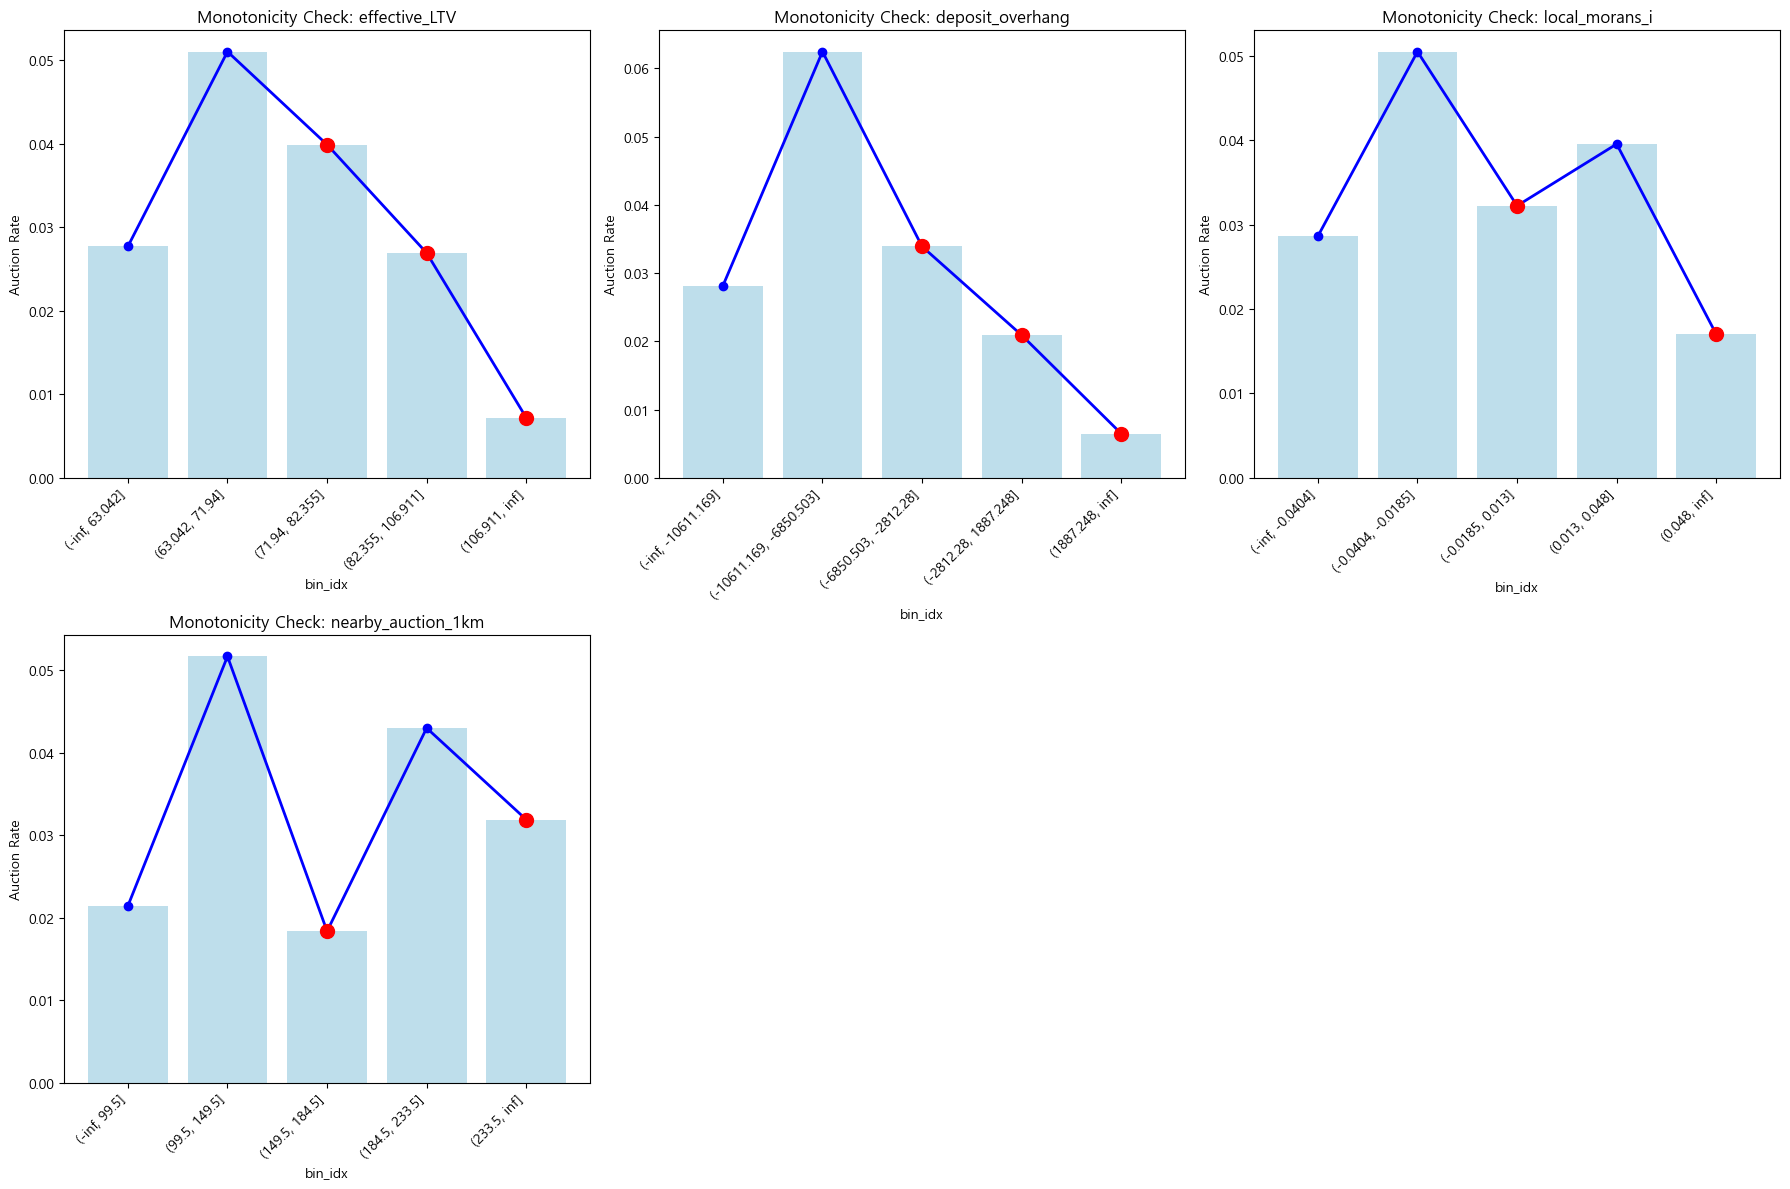

In [51]:
def check_monotonicity_with_dt(df, features, target='경매_4년이내'):
    plt.figure(figsize=(18, 12))
    bins_out = {} # 결과를 담을 딕셔너리 생성

    for i, col in enumerate(features, 1):
        try:
            bins = find_optimal_bins(df, col, target, max_bins=5)
            bins_out[col] = bins # 딕셔너리에 저장
        except Exception as e:
            print(f"Error binning {col}: {e}")
            continue
            
        binned_col = f'{col}_bin'
        df[binned_col] = pd.cut(df[col], bins=bins, labels=False, include_lowest=True)
        
        stats = df.groupby(binned_col)[target].agg(['count', 'mean']).reset_index()
        stats.columns = ['bin_idx', 'Total_Count', 'Bad_Rate']
        
        bin_labels = pd.cut(df[col], bins=bins, include_lowest=True).unique().categories.astype(str)
        stats['bin_range'] = stats['bin_idx'].apply(lambda x: bin_labels[int(x)])
        stats['is_reversed'] = stats['Bad_Rate'].diff() < 0
        
        plt.subplot(2, 3, i)
        sns.barplot(data=stats, x='bin_idx', y='Bad_Rate', alpha=0.6, color='skyblue')
        plt.plot(stats['bin_idx'], stats['Bad_Rate'], marker='o', color='blue', linewidth=2)
        
        reversed_points = stats[stats['is_reversed']]
        if not reversed_points.empty:
            plt.scatter(reversed_points['bin_idx'], reversed_points['Bad_Rate'], color='red', s=100, zorder=5)
        
        plt.title(f'Monotonicity Check: {col}')
        plt.xticks(ticks=stats['bin_idx'], labels=stats['bin_range'], rotation=45, ha='right')
        plt.ylabel('Auction Rate')

    plt.tight_layout()
    plt.show()
    
    return bins_out 

# 변수 리스트 
target_features = ['effective_LTV', 'deposit_overhang', 'local_morans_i', 'nearby_auction_1km']

# 함수 실행 
bins_dict = check_monotonicity_with_dt(df, target_features)

In [52]:
import pandas as pd
import numpy as np

def calculate_woe_iv(df, features, target='경매_4년이내'):
    woe_dicts = {}
    iv_summary = {}
    
    # 전체 Good/Bad 개수 (0: Good, 1: Bad)
    total_bad = df[target].sum()
    total_good = len(df) - total_bad
    
    # 0으로 나누는 것을 방지하기 위한 아주 작은 값
    epsilon = 1e-9

    for col in features:
        bin_col = f'{col}_bin'
        
        # 구간별 통계
        stats = df.groupby(bin_col)[target].agg(['count', 'sum']).reset_index()
        stats.columns = [bin_col, 'total', 'bad']
        stats['good'] = stats['total'] - stats['bad']
        
        # WoE 계산: ln((good_dist) / (bad_dist))
        # *주의*: 분자/분모 위치에 따라 부호가 결정됩니다. 
        # 여기서는 ln(Dist_Good / Dist_Bad)를 사용하여 값이 클수록 안전(Good)함을 의미하게 설정합니다.
        stats['dist_good'] = (stats['good'] / total_good) + epsilon
        stats['dist_bad'] = (stats['bad'] / total_bad) + epsilon
        stats['woe'] = np.log(stats['dist_good'] / stats['dist_bad'])
        
        # IV 계산
        stats['iv'] = (stats['dist_good'] - stats['dist_bad']) * stats['woe']
        iv_summary[col] = stats['iv'].sum()
        
        # 결과를 dict로 저장하여 매핑 준비
        woe_dicts[col] = stats.set_index(bin_col)['woe'].to_dict()
        
        # 원본 데이터프레임에 WoE 값 매핑
        df[f'woe_{col}'] = df[bin_col].map(woe_dicts[col])
        
    return df, iv_summary, woe_dicts

# 실행
woe_features = ['effective_LTV', 'deposit_overhang',  'local_morans_i', 'nearby_auction_1km']
df, iv_scores, woe_maps = calculate_woe_iv(df, woe_features)

print("--- [변수별 IV 점수] ---")
for col, iv in iv_scores.items():
    print(f"{col}: {iv:.4f}")

--- [변수별 IV 점수] ---
effective_LTV: 0.4701
deposit_overhang: 0.5429
local_morans_i: 0.1511
nearby_auction_1km: 0.1584


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_vif_woe(df, features):
    # WoE 컬럼명 생성
    woe_cols = [f'woe_{col}' for col in features]
    
    # 결측치 제거 후 독립변수 셋 구성
    X = df[woe_cols].dropna()
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = woe_cols
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(woe_cols))]
    
    return vif_data.sort_values(by="VIF", ascending=False)

# VIF 실행
vif_results = check_vif_woe(df, woe_features)
print("\n--- [WoE 변수간 VIF 결과] ---")
print(vif_results)


--- [WoE 변수간 VIF 결과] ---
                  feature       VIF
1    woe_deposit_overhang  5.243641
0       woe_effective_LTV  5.241407
3  woe_nearby_auction_1km  1.250394
2      woe_local_morans_i  1.248148


변수 선택
사용 변수: 4개
  - woe_effective_LTV
  - woe_deposit_overhang
  - woe_local_morans_i
  - woe_nearby_auction_1km

데이터 준비
전체 데이터: 13992건
경매 비율: 3.29%

Train: 11193건 (경매: 368건, 3.29%)
Test:  2799건 (경매: 92건, 3.29%)

로지스틱 회귀

AUC:
  Train: 0.6703
  Test:  0.6799

계수:
  woe_effective_LTV              +0.0074
  woe_deposit_overhang           -0.6431
  woe_local_morans_i             -0.6505
  woe_nearby_auction_1km         -0.8830
  Intercept: -0.5191

예측 확률:
  일반: 0.4575
  경매: 0.5425
  차이: 0.0851 (1.19배)


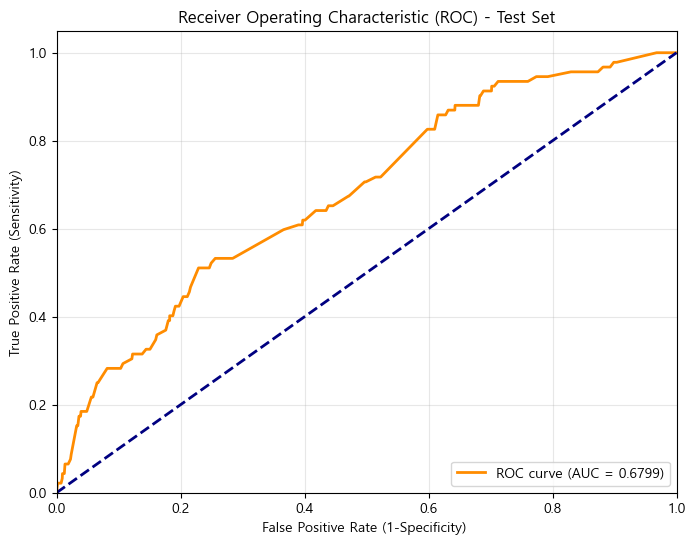


완료


In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. Residual_pct 제거
# ==========================================

print("="*80)
print("변수 선택")
print("="*80)

# 사용할 WoE 변수
selected_woe = ['woe_effective_LTV', 'woe_deposit_overhang', 
                'woe_local_morans_i', 'woe_nearby_auction_1km']

print(f"사용 변수: {len(selected_woe)}개")
for var in selected_woe:
    print(f"  - {var}")

# ==========================================
# 2. 데이터 준비
# ==========================================

print("\n" + "="*80)
print("데이터 준비")
print("="*80)

target = '경매_4년이내'

# 결측치 제거
df_model = df[selected_woe + [target]].dropna()

X = df_model[selected_woe]
y = df_model[target]

print(f"전체 데이터: {len(df_model)}건")
print(f"경매 비율: {y.mean()*100:.2f}%")

# Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {len(X_train)}건 (경매: {y_train.sum()}건, {y_train.mean()*100:.2f}%)")
print(f"Test:  {len(X_test)}건 (경매: {y_test.sum()}건, {y_test.mean()*100:.2f}%)")

# ==========================================
# 3. 로지스틱 회귀
# ==========================================

print("\n" + "="*80)
print("로지스틱 회귀")
print("="*80)

# 모델 학습
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 예측
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# ==========================================
# 4. 성능 평가
# ==========================================

# AUC
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nAUC:")
print(f"  Train: {train_auc:.4f}")
print(f"  Test:  {test_auc:.4f}")

# 계수
print(f"\n계수:")
for feature, coef in zip(selected_woe, model.coef_[0]):
    print(f"  {feature:30s} {coef:+.4f}")
print(f"  Intercept: {model.intercept_[0]:.4f}")

# ==========================================
# 5. 전체 데이터 예측
# ==========================================

# 전체 데이터에 예측 확률 추가
df['경매_확률_LR'] = np.nan
df.loc[df_model.index, '경매_확률_LR'] = model.predict_proba(df_model[selected_woe])[:, 1]

# 경매 여부별 평균 확률
g0 = df[df[target]==0]['경매_확률_LR'].mean()
g1 = df[df[target]==1]['경매_확률_LR'].mean()

print(f"\n예측 확률:")
print(f"  일반: {g0:.4f}")
print(f"  경매: {g1:.4f}")
print(f"  차이: {g1-g0:.4f} ({g1/g0:.2f}배)")

# ==========================================
# 6. ROC Curve 시각화
# ==========================================
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity) ')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) - Test Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print("\n" + "="*80)
print("완료")
print("="*80)

분위수 기준:
  고위험 (상위 10%): 0.6346 이상
  주의 (상위 30%): 0.5314 이상
  안전: 0.5314 미만

등급별 통계
    위험등급  전체매물수  실제경매건수     경매발생률      적중배수
0  1_고위험   1403     123  0.087669  3.589866
1   2_주의   2798     129  0.046104  1.887873
2   3_안전  14635     208  0.014213  0.581971

전체 평균 발생률: 2.44%


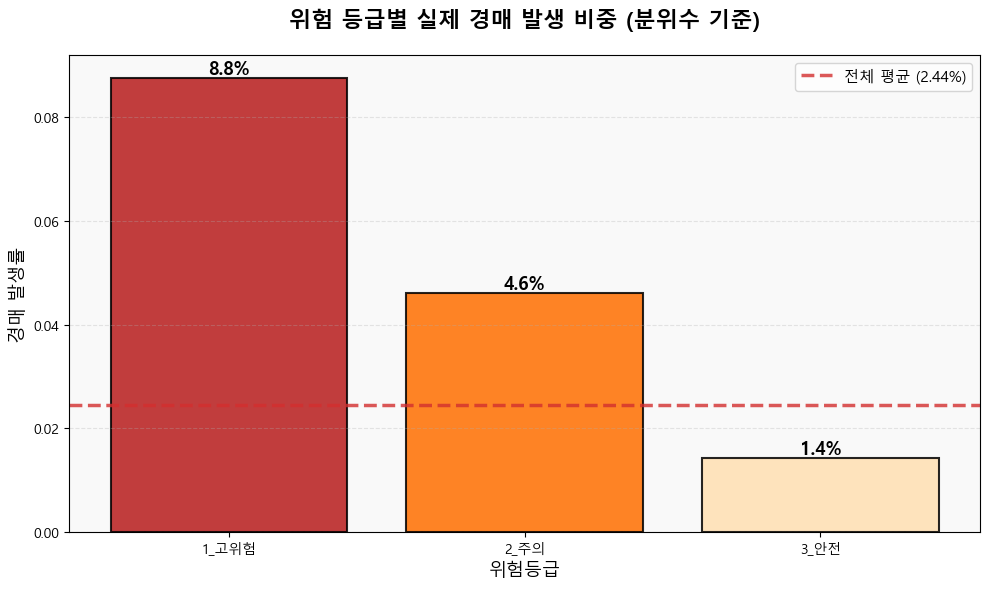

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 분위수 기준 계산
# ==========================================

q90 = df['경매_확률_LR'].quantile(0.9)  # 상위 10%
q70 = df['경매_확률_LR'].quantile(0.7)  # 상위 30%

print(f"분위수 기준:")
print(f"  고위험 (상위 10%): {q90:.4f} 이상")
print(f"  주의 (상위 30%): {q70:.4f} 이상")
print(f"  안전: {q70:.4f} 미만\n")

# ==========================================
# 2. 위험 등급 분류
# ==========================================

def get_risk_grade(prob):
    if prob >= q90: return '1_고위험'
    elif prob >= q70: return '2_주의'
    else: return '3_안전'

df['risk_grade'] = df['경매_확률_LR'].apply(get_risk_grade)

# ==========================================
# 3. 통계 계산
# ==========================================

risk_summary = df.groupby('risk_grade').agg({
    '경매_4년이내': ['count', 'sum', 'mean']
}).reset_index()
risk_summary.columns = ['위험등급', '전체매물수', '실제경매건수', '경매발생률']

overall_avg = df['경매_4년이내'].mean()
risk_summary['적중배수'] = risk_summary['경매발생률'] / overall_avg

print("="*60)
print("등급별 통계")
print("="*60)
print(risk_summary)
print(f"\n전체 평균 발생률: {overall_avg*100:.2f}%")
print("="*60)

# ==========================================
# 4. 시각화
# ==========================================

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#b71c1c', '#ff6f00', '#ffe0b2'] 
bars = ax.bar(risk_summary['위험등급'], risk_summary['경매발생률'], 
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)

# 평균선
ax.axhline(overall_avg, color='#d32f2f', linestyle='--', linewidth=2.5, 
           label=f'전체 평균 ({overall_avg*100:.2f}%)', alpha=0.8)

# 수치 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height*100:.1f}%',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

ax.set_title('위험 등급별 실제 경매 발생 비중 (분위수 기준)', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('경매 발생률', fontsize=13)
ax.set_xlabel('위험등급', fontsize=13)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_facecolor('#f9f9f9')
plt.tight_layout()
plt.show()

In [43]:
import joblib

# 시스템 배포용 패키지 구성
model_package = {
    'model': model,              # 학습된 로지스틱 회귀 모델
    'bins_config': bins_dict,  # 변수별 절단점(Bin edges)
    'woe_maps': woe_maps,        # 변수별 구간 인덱스:WoE 매핑 사전
    'features': [                # 모델에 사용된 원본 변수 리스트
        'effective_LTV', 
        'deposit_overhang', 
        'local_morans_i', 
        'nearby_auction_1km'
    ]
}

# 파일 저장
model_filename = 'hwagok_auction_risk_model.pkl'
joblib.dump(model_package, model_filename)

print(f"✓ 모델 패키지가 '{model_filename}'으로 저장되었습니다.")

✓ 모델 패키지가 'hwagok_auction_risk_model.pkl'으로 저장되었습니다.
